In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from PIL import Image
import umap
import os


C:\Users\Christian\Documents\PYTHON\simplify_pixel_art_color_palette\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Settings ---
base_dir = os.path.abspath(os.getcwd())
file_name = 'castle_turret.png'
input_path = os.path.join(base_dir, 'projects', 'castle', file_name)
output_path = os.path.join(base_dir, 'projects', 'castle', file_name[:-4] + '_simplified' + file_name[-4:])
use_umap = False  # Set to False to use t-SNE
dbscan_eps = 5
dbscan_min_samples = 15

In [3]:
# Load RGBA image
img_rgba = Image.open(input_path).convert("RGBA")
img_data = np.array(img_rgba)
h, w, _ = img_data.shape
rgb = img_data[:, :, :3].reshape(-1, 3)
alpha = img_data[:, :, 3].reshape(-1)

# Create a mask for visible (non-transparent) pixels
visible_mask = alpha > 0
pixels = rgb[visible_mask]

In [4]:
type(img_rgba)

PIL.Image.Image

In [5]:
pixels.shape

(5172, 3)

In [6]:
len(np.unique(pixels))  # number of unique pixel values originally

180


# --- Dimensionality Reduction for visualization ---
if use_umap:
    reducer = umap.UMAP(n_components=2, random_state=42)
else:
    reducer = TSNE(n_components=2, random_state=42)

embedding = reducer.fit_transform(pixels)

# --- Plot color distribution ---
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=pixels / 255.0, s=0.5)
plt.title("2D Projection of Pixel Colors")
plt.axis('off')
plt.tight_layout()
plt.show()


Generating elbow plot...


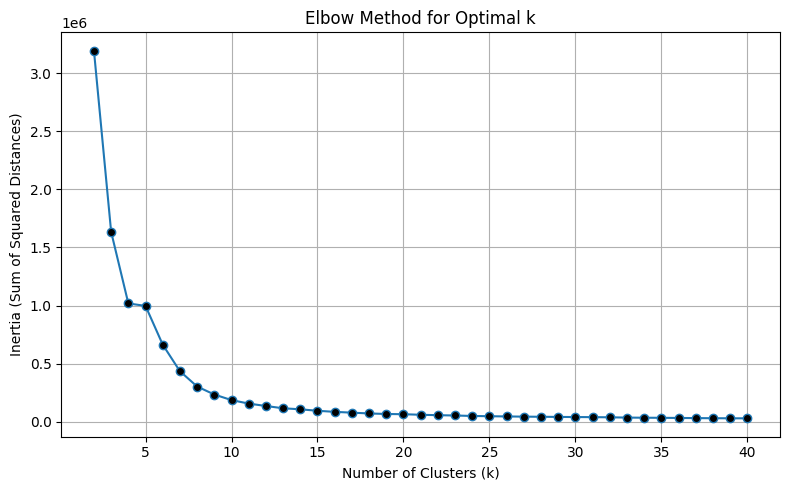

In [7]:
# --- K-means Elbow Plot ---
inertias = []
k_values = range(2, 41)

print("Generating elbow plot...")
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(pixels)
    inertias.append(km.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', markerfacecolor='black')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
#plt.savefig("elbow_plot.png", dpi=300)
plt.show()

In [8]:
]

SyntaxError: unmatched ']' (1890416573.py, line 1)

In [13]:
optimal_k = 8  # ← Change this after looking at the elbow plot

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(pixels)
centroids = kmeans.cluster_centers_.astype(np.uint8)

# Start with all pixels set to transparent
new_rgb = np.zeros_like(rgb)
new_alpha = np.zeros_like(alpha)

# Assign clustered RGB to visible pixels
new_rgb[visible_mask] = centroids[labels]
new_alpha[visible_mask] = 255  # Fully opaque

# Combine RGB and alpha
new_img_array = np.concatenate(
    [new_rgb, new_alpha[:, np.newaxis]], axis=1
).reshape(h, w, 4)

In [14]:
# --- Save result ---
Image.fromarray(new_img_array, mode="RGBA").save(output_path, format="PNG", compress_level=0)
print(f"Saved reduced-palette image to {output_path}")


Saved reduced-palette image to C:\Users\Christian\Documents\PYTHON\simplify_pixel_art_color_palette\projects\castle\castle_turret_simplified.png
